## P2P Lending Dataset Preparation

##### Luis Eduardo Boiko Ferreira,  PPGIa - PUCPR, luiseduardo.boiko@ppgia.pucpr.br
##### Jean Paul Barddal,  PPGIa - PUCPR, jean.barddal@ppgia.pucpr.br
##### Heitor Murilo Gomes, INFRES - Institut Mines-Télécom, heitor.gomes@telecom-paristech.fr
##### Fabrício Enembreck, PPGIa - PUCPR, fabricio@ppgia.pucpr.br

This script has the goal of merging the data made available from [Lending Club](https://www.lendingclub.com) between 2007 and 2016.
In this work, we tackle only "Charged Off" and "Fully Paid" loans.
The main steps taken to prepare the dataset are the following:

1. Data load and header sanity check
2. Data filter (charged off and fully paid) and concatenation
3. Removal of features to avoid data leakage
4. Removal and treatment of string variables
5. Removal of instances (loan requests) with many missing values
6. Removal of features (attributes) with many missing values
7. Removal of variables of low variability
8. Missing values imputation

It is also important to mention that this script prepares two different versions of the dataset.
The first is outputted between steps #4 and #5, and the other after step #8.
The idea is to verify if the pre-processing that takes place between steps #5 and #8 impact somehow the learning algorithms and sampling techniques.

#### In this notebook we also sort the data by column 'id' and we build decision trees for windows

### 1. Data load and header sanity check

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt

# to export the tree structure
from sklearn.tree.export import export_text

# BM
# for the ceil function
import math
# for the decision tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
# for paths and logging
import os
# for logging purposes
import logging
# import the label encoded from sklearn
from sklearn.preprocessing import LabelEncoder

__file__ = 'detect_concept_drift'

# delete the previous log file
# os.remove(os.path.realpath(__file__) + '.log')

# initializing the logger
logging.basicConfig(filename=os.path.realpath(__file__) + '.log',
                    filemode='a',
                    format='%(asctime)s %(levelname)s %(message)s',
                    datefmt='%H:%M:%S',
                    level=logging.DEBUG)

logging.info("Initialized logger")
print("Initialized logger")

%matplotlib inline

sort_by_issue_d = True

Initialized logger


C:\Users\berna\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.tree.export module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#### Loads all datasets
df2007to2011 = pd.read_csv("datasets/LoanStats3a_securev1.csv", low_memory=False, skiprows=[0])
df2012to2013 = pd.read_csv("datasets/LoanStats3b_securev1.csv", low_memory=False, skiprows=[0])
df2014       = pd.read_csv("datasets/LoanStats3c_securev1.csv", low_memory=False, skiprows=[0])
df2015       = pd.read_csv("datasets/LoanStats3d_securev1.csv", low_memory=False, skiprows=[0])
df2016Q1     = pd.read_csv("datasets/LoanStats_securev1_2016Q1.csv", low_memory=False, skiprows=[0])
df2016Q2     = pd.read_csv("datasets/LoanStats_securev1_2016Q2.csv", low_memory=False, skiprows=[0])
df2016Q3     = pd.read_csv("datasets/LoanStats_securev1_2016Q3.csv", low_memory=False, skiprows=[0])
df2016Q4     = pd.read_csv("datasets/LoanStats_securev1_2016Q4.csv", low_memory=False, skiprows=[0])

In [3]:
# remove rows which have a string under the ID column
df2007to2011 = df2007to2011[df2007to2011.id.str.isnumeric()]
df2012to2013 = df2012to2013[df2012to2013.id.str.isnumeric()]
df2014 = df2014[df2014.id.str.isnumeric()]
df2015 = df2015[df2015.id.str.isnumeric()]
df2016Q1 = df2016Q1[df2016Q1.id.str.isnumeric()]
df2016Q2 = df2016Q2[df2016Q2.id.str.isnumeric()]
df2016Q3 = df2016Q3[df2016Q3.id.str.isnumeric()]
df2016Q4 = df2016Q4[df2016Q4.id.str.isnumeric()]

In [4]:
# set the ID column as numeric
df2007to2011['id'] = df2007to2011['id'].astype(np.int64)
df2012to2013['id'] = df2012to2013['id'].astype(np.int64)
df2014['id'] = df2014['id'].astype(np.int64)
df2015['id'] = df2015['id'].astype(np.int64)
df2016Q1['id'] = df2016Q1['id'].astype(np.int64)
df2016Q2['id'] = df2016Q2['id'].astype(np.int64)
df2016Q3['id'] = df2016Q3['id'].astype(np.int64)
df2016Q4['id'] = df2016Q4['id'].astype(np.int64)

In [5]:
# TREAT the DATE issue_d columns
def separateDates(dataframe, columns):
    for f in columns:
        dataframe[f] = pd.to_datetime(dataframe[f], format='%b-%Y')
        year = dataframe[f].apply(lambda x: x.strftime('%Y') if not pd.isnull(x) else '')
        month = dataframe[f].apply(lambda x: x.strftime('%m') if not pd.isnull(x) else '')
        dataframe[(f + '_month')] = month
        dataframe[(f + '_year')] = year
        dataframe[(f + '_month')] = pd.to_numeric(dataframe[(f + '_month')])
        dataframe[(f + '_year')] = pd.to_numeric(dataframe[(f + '_year')])
    return dataframe

In [6]:
# seperate the issue_d
df2007to2011['issue_d_new'] = df2007to2011['issue_d']
df2007to2011 = separateDates(df2007to2011, ['issue_d_new'])
# combine the year and month into one number
df2007to2011['date_no'] = (df2007to2011['issue_d_new_year'] * df2007to2011['issue_d_new_year']) + df2007to2011["issue_d_new_month"]
# Converts this column to numbers, just in case.
df2007to2011['date_no'] = pd.to_numeric(df2007to2011['date_no'], errors='ignore')

df2012to2013['issue_d_new'] = df2012to2013['issue_d']
df2012to2013 = separateDates(df2012to2013, ['issue_d_new'])
# combine the year and month into one number
df2012to2013['date_no'] = (df2012to2013['issue_d_new_year'] * df2012to2013['issue_d_new_year']) + df2012to2013["issue_d_new_month"]
# Converts this column to numbers, just in case.
df2012to2013['date_no'] = pd.to_numeric(df2012to2013['date_no'], errors='ignore')

df2014['issue_d_new'] = df2014['issue_d']
df2014 = separateDates(df2014, ['issue_d_new'])
# combine the year and month into one number
df2014['date_no'] = (df2014['issue_d_new_year'] * df2014['issue_d_new_year']) + df2014["issue_d_new_month"]
# Converts this column to numbers, just in case.
df2014['date_no'] = pd.to_numeric(df2014['date_no'], errors='ignore')

df2015['issue_d_new'] = df2015['issue_d']
df2015 = separateDates(df2015, ['issue_d_new'])
# combine the year and month into one number
df2015['date_no'] = (df2015['issue_d_new_year'] * df2015['issue_d_new_year']) + df2015["issue_d_new_month"]
# Converts this column to numbers, just in case.
df2015['date_no'] = pd.to_numeric(df2015['date_no'], errors='ignore')

df2016Q1['issue_d_new'] = df2016Q1['issue_d']
df2016Q1 = separateDates(df2016Q1, ['issue_d_new'])
# combine the year and month into one number
df2016Q1['date_no'] = (df2016Q1['issue_d_new_year'] * df2016Q1['issue_d_new_year']) + df2016Q1["issue_d_new_month"]
# Converts this column to numbers, just in case.
df2016Q1['date_no'] = pd.to_numeric(df2016Q1['date_no'], errors='ignore')

df2016Q2['issue_d_new'] = df2016Q2['issue_d']
df2016Q2 = separateDates(df2016Q2, ['issue_d_new'])
# combine the year and month into one number
df2016Q2['date_no'] = (df2016Q2['issue_d_new_year'] * df2016Q2['issue_d_new_year']) + df2016Q2["issue_d_new_month"]
# Converts this column to numbers, just in case.
df2016Q2['date_no'] = pd.to_numeric(df2016Q2['date_no'], errors='ignore')

df2016Q3['issue_d_new'] = df2016Q3['issue_d']
df2016Q3 = separateDates(df2016Q3, ['issue_d_new'])
# combine the year and month into one number
df2016Q3['date_no'] = (df2016Q3['issue_d_new_year'] * df2016Q3['issue_d_new_year']) + df2016Q3["issue_d_new_month"]
# Converts this column to numbers, just in case.
df2016Q3['date_no'] = pd.to_numeric(df2016Q3['date_no'], errors='ignore')

df2016Q4['issue_d_new'] = df2016Q4['issue_d']
df2016Q4 = separateDates(df2016Q4, ['issue_d_new'])
# combine the year and month into one number
df2016Q4['date_no'] = (df2016Q4['issue_d_new_year'] * df2016Q4['issue_d_new_year']) + df2016Q4["issue_d_new_month"]
# Converts this column to numbers, just in case.
df2016Q4['date_no'] = pd.to_numeric(df2016Q4['date_no'], errors='ignore')

In [7]:
# sort according to the loan listing id and issue date
df2007to2011 = df2007to2011.sort_values(['date_no', 'id'],  ascending=[True, True])
df2012to2013 = df2012to2013.sort_values(['date_no', 'id'],  ascending=[True, True])
df2014 = df2014.sort_values(['date_no', 'id'],  ascending=[True, True])
df2015 = df2015.sort_values(['date_no', 'id'],  ascending=[True, True])
df2016Q1 = df2016Q1.sort_values(['date_no', 'id'],  ascending=[True, True])
df2016Q2 = df2016Q2.sort_values(['date_no', 'id'],  ascending=[True, True])
df2016Q3 = df2016Q3.sort_values(['date_no', 'id'],  ascending=[True, True])
df2016Q4 = df2016Q4.sort_values(['date_no', 'id'],  ascending=[True, True])

In [8]:
# join all sets
all_dfs = [df2007to2011, df2012to2013, df2014, df2015, df2016Q1, df2016Q2, df2016Q3, df2016Q4]

# concatinate to have one complete set from 2007 till 2016
df = pd.concat(all_dfs)

In [9]:
df.head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sec_app_revol_util,sec_app_open_il_6m,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,issue_d_new,issue_d_new_month,issue_d_new_year,date_no
42535,70686,NaN,5000.0,5000.0,0.0,36 months,7.75%,156.11,A,A3,...,NaN,NaN,NaN,NaN,NaN,NaN,2007-06-01,6,2007,4028055
42534,71623,NaN,6500.0,6500.0,0.0,36 months,8.38%,204.84,A,A5,...,NaN,NaN,NaN,NaN,NaN,NaN,2007-06-01,6,2007,4028055
42533,72176,NaN,2525.0,2525.0,225.0,36 months,9.33%,80.69,B,B3,...,NaN,NaN,NaN,NaN,NaN,NaN,2007-06-01,6,2007,4028055
42532,72998,NaN,1000.0,1000.0,0.0,36 months,9.64%,32.11,B,B4,...,NaN,NaN,NaN,NaN,NaN,NaN,2007-06-01,6,2007,4028055
42531,73582,NaN,3500.0,3500.0,225.0,36 months,10.28%,113.39,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,2007-06-01,6,2007,4028055


### 2. Data filter (charged off and fully paid) and concatenation

In [10]:
#### Replaces 'loan_status' "'Does not meet the credit policy. Status:Charged Off' 'Current'" 
#### and "'Does not meet the credit policy. Status:Fully Paid'"
df['loan_status'] = df['loan_status'].replace("'Does not meet the credit policy. Status:Charged Off' 'Current'",
                                              "Charged Off")
df['loan_status'] = df['loan_status'].replace("'Does not meet the credit policy. Status:Fully Paid'", 
                                              "Fully Paid")



#### Filters dataset to contain only "Charged Off" and "Fully Paid" loans
df = df.loc[(df.loan_status == "Charged Off") | (df.loan_status == "Fully Paid")]


#### Converts the class to 0s and 1s
df['loan_status'] = df['loan_status'].replace("Charged Off", 1)
df['loan_status'] = df['loan_status'].replace("Fully Paid", 0)

#### Converts this column to numbers, just in case.
df['loan_status'] = pd.to_numeric(df['loan_status'], errors='ignore')

df.set_index('id', inplace = True)
df.reset_index(inplace = True)

#### There are some missing values listed as a string 
#### in the 'n/a' format, so let's replace these for treatment later
df.replace('n/a', np.nan, inplace = True)

# BM removed the below sort
#### Sorts the dataset for the sake of visualization purposes
# df.sort_index(inplace = True)
# print(df.shape)

In [11]:
df.head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sec_app_revol_util,sec_app_open_il_6m,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,issue_d_new,issue_d_new_month,issue_d_new_year,date_no
0,87023,NaN,7500.0,7500.0,800.0,36 months,13.75%,255.43,E,E2,...,NaN,NaN,NaN,NaN,NaN,NaN,2007-06-01,6,2007,4028055
1,76597,NaN,5000.0,5000.0,1775.0,36 months,9.01%,159.03,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,2007-07-01,7,2007,4028056
2,90376,NaN,5000.0,5000.0,650.0,36 months,7.43%,155.38,A,A2,...,NaN,NaN,NaN,NaN,NaN,NaN,2007-07-01,7,2007,4028056
3,90395,NaN,5000.0,5000.0,1325.0,36 months,8.07%,156.84,A,A4,...,NaN,NaN,NaN,NaN,NaN,NaN,2007-07-01,7,2007,4028056
4,90665,NaN,8500.0,8500.0,875.0,36 months,10.28%,275.38,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,2007-07-01,7,2007,4028056


### 3. Removal of features to avoid data leakage

In [12]:
#### Here, we keep only the variables listed in the dictionary file

# BM added issue_d and id
featuresToKeep = ['id', 'issue_d', 'acc_open_past_24mths','addr_state','annual_inc', 
                 'annual_inc_joint','application_type','avg_cur_bal', 
                 'bc_open_to_buy','bc_util','chargeoff_within_12_mths', 
                 'collections_12_mths_ex_med','delinq_2yrs','delinq_amnt',
                 'dti','dti_joint','earliest_cr_line','emp_length', 
                 'fico_range_high','fico_range_low','grade','home_ownership', 
                 'initial_list_status','inq_last_6mths','installment',
                 'int_rate', 'loan_amnt','mths_since_last_delinq', 
                 'mths_since_last_major_derog','mths_since_last_record', 
                 'num_accts_ever_120_pd','open_acc','pub_rec', 
                 'pub_rec_bankruptcies','revol_bal','revol_bal_joint', 
                 'revol_util','sec_app_chargeoff_within_12_mths', 
                 'sec_app_collections_12_mths_ex_med','sec_app_earliest_cr_line', 
                 'sec_app_fico_range_high','sec_app_fico_range_low', 
                 'sec_app_inq_last_6mths','sec_app_mort_acc', 
                 'sec_app_mths_since_last_major_derog', 
                 'sec_app_num_rev_accts','sec_app_open_acc', 
                 'sec_app_open_il_6m','sec_app_revol_util', 
                 'sub_grade','tax_liens','term','tot_hi_cred_lim', 
                 'total_acc','total_bal_ex_mort','total_bc_limit', 
                 'total_il_high_credit_limit','total_rev_hi_lim', 
                 'verification_status', 'loan_status']

df = df[featuresToKeep]

In [13]:
df.head(5)

,id,issue_d,acc_open_past_24mths,addr_state,annual_inc,annual_inc_joint,application_type,avg_cur_bal,bc_open_to_buy,bc_util,...,tax_liens,term,tot_hi_cred_lim,total_acc,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,total_rev_hi_lim,verification_status,loan_status
0,87023,Jun-2007,NaN,MA,22000.0,NaN,INDIVIDUAL,NaN,NaN,NaN,...,NaN,36 months,NaN,8.0,NaN,NaN,NaN,NaN,Not Verified,0
1,76597,Jul-2007,NaN,NY,250000.0,NaN,INDIVIDUAL,NaN,NaN,NaN,...,NaN,36 months,NaN,7.0,NaN,NaN,NaN,NaN,Not Verified,0
2,90376,Jul-2007,NaN,MD,200000.0,NaN,INDIVIDUAL,NaN,NaN,NaN,...,NaN,36 months,NaN,26.0,NaN,NaN,NaN,NaN,Not Verified,0
3,90395,Jul-2007,NaN,MA,100000.0,NaN,INDIVIDUAL,NaN,NaN,NaN,...,NaN,36 months,NaN,20.0,NaN,NaN,NaN,NaN,Not Verified,0
4,90665,Jul-2007,NaN,NC,18000.0,NaN,INDIVIDUAL,NaN,NaN,NaN,...,NaN,36 months,NaN,9.0,NaN,NaN,NaN,NaN,Not Verified,0


### 4. Removal and treatment of string variables

In [14]:
df_string = df.select_dtypes(exclude=[np.number])
# print(df_string.shape)
pd.set_option('display.max_columns', 30)
# display(df_string.head(1))

print("Cleaning up numeric data...")
#### Converts some features to numeric
def convertToNumeric(dataframe, list_of_attributes):
    for f in list_of_attributes:
        dataframe[f].replace(regex = True, inplace=True, to_replace=r'[^\d.]+', value = r'')
        dataframe[f] = pd.to_numeric(dataframe[f], errors='ignore')

features_to_convert_to_numeric = ['term', 
                                  'revol_util', 
                                  'int_rate']
convertToNumeric(df, features_to_convert_to_numeric)


print("Applying one hot encoding...")
#### Applies one-hot-encoding to categorical variables
def oneHotEncoding(dataframe, columnsToEncode):
    new_dummies = []
    for feature in columnsToEncode:
        # creates dummies
        dummies = pd.get_dummies(dataframe[feature], prefix=feature, prefix_sep='_')
        for v in dummies.columns.values:
            new_dummies.append(v)
        # drops the feature
        dataframe.drop(feature, axis = 1, inplace = True)
        # appends n-1 features (the last is not necessary)
        dummies.drop(dummies.columns[len(dummies.columns)-1], axis = 1, inplace=True)
        dataframe = dataframe.join(dummies)
    return dataframe, new_dummies

categorical_features = ['grade', 
                        'sub_grade', 
                        'emp_length', 
                        'home_ownership', 
                        'verification_status', 
                        'addr_state', 
                        'initial_list_status', 
                        'application_type']
# df, new_dummies = oneHotEncoding(df, categorical_features)

print("Cleaning up date data...")
#### TREATS DATE COLUMNS
from datetime import datetime
def separateDates(dataframe, columns):
    for f in columns:
        dataframe[f] = pd.to_datetime(dataframe[f], format='%b-%Y')
        year = dataframe[f].apply(lambda x: x.strftime('%Y') if not pd.isnull(x) else '')
        month = dataframe[f].apply(lambda x: x.strftime('%m') if not pd.isnull(x) else '')    
        dataframe.drop(f, axis = 1, inplace = True)
        df[(f + '_month')] = month
        df[(f + '_year')] = year
        df[(f + '_month')] = pd.to_numeric(df[(f + '_month')])
        df[(f + '_year')] = pd.to_numeric(df[(f + '_year')])        
    return df

date_columns = ['earliest_cr_line']
# all of these dates are in the mmm-YYYY format
# and we wish to break them down into two separate columns: mm and YYYY
df = separateDates(df, date_columns)

print("The new shape is now {}".format(df.shape))
# display(df.head(1))
# print(new_dummies)

Cleaning up numeric data...
Applying one hot encoding...
Cleaning up date data...
The new shape is now (578331, 61)


### 4. Removal of instances (loan requests) with many missing values

In [15]:
#### Getting rid of instances with too many missing values (above 90%)
df.dropna(thresh = 0.5 * df.shape[1], axis = 0, inplace = True)
display(df.shape)

(578324, 61)

### 5. Removal of features (attributes) with many missing values

In [16]:
#### Removes all features with more than 50% of the values missing
df.dropna(thresh = 0.5 * df.shape[0], axis = 1, inplace = True)
display(df.shape)

(578324, 43)

### 6. Removal of variables of low variability (below 25%)

In [17]:
toRemove = []
for attribute in df.columns.values:
    if attribute != 'loan_status' and attribute not in categorical_features:
    # if attribute != 'loan_status' and attribute not in new_dummies:
        count = pd.Series.value_counts(df[attribute])
        maxCount = np.max(count)
        variability = 1.0 - (float(maxCount) / count.sum())
        if variability < .25:
            print("{} has a variability of {}".format(attribute, variability))            
            toRemove.append(attribute)
            
            
for f in toRemove:
    df.drop(f, axis = 1, inplace = True)
print(df.shape)

chargeoff_within_12_mths has a variability of 0.007214560546452864
collections_12_mths_ex_med has a variability of 0.011065669447926973
delinq_2yrs has a variability of 0.18065651779971093
delinq_amnt has a variability of 0.0031280043712520467
num_accts_ever_120_pd has a variability of 0.22768339043506824
pub_rec has a variability of 0.15178861676153854
pub_rec_bankruptcies has a variability of 0.11668634464037786
tax_liens has a variability of 0.02426109992875569
term has a variability of 0.23898541302107468
(578324, 34)


### 8. Missing values imputation

In [18]:
#### Numeric features are imputed with the median, 
#### while categorical features are imputed with the mode
for f in df.columns.values:
    if df[f].dtype == np.float64 or df[f].dtype == np.int64:
        df[f].fillna(df[f].median(),inplace = True)
    else:
        df[f].fillna(df[f].value_counts().index[0], inplace = True)
print (df.shape)

df.groupby(['loan_status']).count()

(578324, 34)


,id,issue_d,acc_open_past_24mths,addr_state,annual_inc,application_type,avg_cur_bal,bc_open_to_buy,bc_util,dti,emp_length,fico_range_high,fico_range_low,grade,home_ownership,...,int_rate,loan_amnt,open_acc,revol_bal,revol_util,sub_grade,tot_hi_cred_lim,total_acc,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,total_rev_hi_lim,verification_status,earliest_cr_line_month,earliest_cr_line_year
loan_status,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,461001,461001,461001,461001,461001,461001,461001,461001,461001,461001,461001,461001,461001,461001,461001,...,461001,461001,461001,461001,461001,461001,461001,461001,461001,461001,461001,461001,461001,461001,461001
1,117323,117323,117323,117323,117323,117323,117323,117323,117323,117323,117323,117323,117323,117323,117323,...,117323,117323,117323,117323,117323,117323,117323,117323,117323,117323,117323,117323,117323,117323,117323


#### BM Calculating class imbalance

In [19]:
print("There are", round(len(df[df.loan_status==1].index)/len(df.loan_status.index)*100,2),"% which are defualters")

There are 20.29 % which are defualters


#### From here onwards we build decision trees

#### Generate the windows

In [20]:
window_size = 5000
step = 1000

num_of_iterations = math.ceil(((len(df.index)-window_size)/step)+1)

print(num_of_iterations)

575


In [21]:
df.to_csv('./datasets/p2p_lending_filtered.csv', index = False)

In [22]:
df.head(5)

,id,issue_d,acc_open_past_24mths,addr_state,annual_inc,application_type,avg_cur_bal,bc_open_to_buy,bc_util,dti,emp_length,fico_range_high,fico_range_low,grade,home_ownership,...,loan_amnt,open_acc,revol_bal,revol_util,sub_grade,tot_hi_cred_lim,total_acc,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,total_rev_hi_lim,verification_status,loan_status,earliest_cr_line_month,earliest_cr_line_year
0,87023,Jun-2007,4.0,MA,22000.0,INDIVIDUAL,7534.0,4056.0,66.5,14.29,< 1 year,664.0,660.0,E,OWN,...,7500.0,7.0,4175.0,51.5,E2,111279.0,8.0,36125.0,14300.0,30032.0,23100.0,Not Verified,0,10,2003
2,90376,Jul-2007,4.0,MD,200000.0,INDIVIDUAL,7534.0,4056.0,66.5,3.72,< 1 year,814.0,810.0,A,MORTGAGE,...,5000.0,17.0,85607.0,0.7,A2,111279.0,26.0,36125.0,14300.0,30032.0,23100.0,Not Verified,0,11,1988
3,90395,Jul-2007,4.0,MA,100000.0,INDIVIDUAL,7534.0,4056.0,66.5,2.30,< 1 year,744.0,740.0,A,MORTGAGE,...,5000.0,11.0,9698.0,19.4,A4,111279.0,20.0,36125.0,14300.0,30032.0,23100.0,Not Verified,0,10,1998
4,90665,Jul-2007,4.0,NC,18000.0,INDIVIDUAL,7534.0,4056.0,66.5,6.40,3 years,694.0,690.0,C,RENT,...,8500.0,6.0,8847.0,26.9,C1,111279.0,9.0,36125.0,14300.0,30032.0,23100.0,Not Verified,0,12,1986
5,90966,Jul-2007,4.0,GA,150000.0,INDIVIDUAL,7534.0,4056.0,66.5,0.00,8 years,779.0,775.0,A,MORTGAGE,...,5000.0,2.0,6053.0,19.5,A2,111279.0,19.0,36125.0,14300.0,30032.0,23100.0,Not Verified,0,12,1987


In [23]:
def get_feature_number(text):
    text_after = text.split("|--- ",1)[1]
    number = text_after.split(" ", 1)[0]
    return int(number.split("_",1)[1])

In [24]:
def get_feature_level(text):
    return text.count('|   ')

In [25]:
# TREAT the DATE issue_d columns
def separateDates(dataframe, columns):
    for f in columns:
        dataframe[f] = pd.to_datetime(dataframe[f], format='%b-%Y')
        year = dataframe[f].apply(lambda x: x.strftime('%Y') if not pd.isnull(x) else '')
        month = dataframe[f].apply(lambda x: x.strftime('%m') if not pd.isnull(x) else '')
        dataframe[(f + '_month')] = month
        dataframe[(f + '_year')] = year
        dataframe[(f + '_month')] = pd.to_numeric(dataframe[(f + '_month')])
        dataframe[(f + '_year')] = pd.to_numeric(dataframe[(f + '_year')])
    return dataframe

In [26]:
# dataframe for issue_d frequency count
df_issue_d_freq = pd.DataFrame({'issue_d': df.issue_d.unique()})
df_issue_d_freq['issue_d_orig'] = df_issue_d_freq['issue_d']

# seperate the dates
df_issue_d_freq = separateDates(df_issue_d_freq, ['issue_d'])

# sort by year and then by month
df_issue_d_freq = df_issue_d_freq.sort_values(['issue_d_year', 'issue_d_month'], ascending=[True, True])

# another dataframe to use
df_to_use = df

# retrieve the records and do frequency counts for issue_d per window
for i in range(0, num_of_iterations):
    to_use = pd.DataFrame()
    
    if len(df_to_use.index) >= window_size:
    
        # retrieve the first number of records using the window size
        to_use = df_to_use.head(window_size)
        
        # remove the first n (step size) rows
        df_to_use = df_to_use.iloc[step:]
        
    else:
        
        # retrieve the first number of records using the size of the dataframe since it's the last window
        to_use = df_to_use.head(len(df_to_use.index))
    
    # get the frequency count of column issue_d    
    df_issue_d_freq['tree_' + str(i)] = df_issue_d_freq['issue_d_orig'].map(to_use['issue_d'].value_counts())

In [27]:
# save the issue_d frequency per window tree to csv
df_issue_d_freq = df_issue_d_freq.drop(['issue_d'], axis = 1)
df_issue_d_freq.to_csv('issue_d_window_freq.csv', index = False)

In [28]:
# drop the column since there is no use for it anymore
df = df.drop(['issue_d', 'id'], axis = 1)

In [29]:
# function that applies label encoding to the string categorical features
def apply_label_encoding(data):
    
    # creating instance of labelencoder
    labelencoder = LabelEncoder()
    
    # Assigning numerical values and storing in another column
    data['grade'] = labelencoder.fit_transform(data['grade'])
    data['sub_grade'] = labelencoder.fit_transform(data['sub_grade'])
    data['emp_length'] = labelencoder.fit_transform(data['emp_length'])
    data['home_ownership'] = labelencoder.fit_transform(data['home_ownership'])
    data['verification_status'] = labelencoder.fit_transform(data['verification_status'])
    data['addr_state'] = labelencoder.fit_transform(data['addr_state'])
    data['initial_list_status'] = labelencoder.fit_transform(data['initial_list_status'])
    data['application_type'] = labelencoder.fit_transform(data['application_type'])
    
    return data

df = apply_label_encoding(df)

In [30]:
orig_df = df

In [31]:
df = orig_df
# create a dataframe which will store the feature levels
index = df.columns.tolist()
index.remove('loan_status')
feature_levels = pd.DataFrame({'features': index})

# create a column to store the number of NAs for each feature
feature_levels['all_NAs'] = False
feature_levels['no_of_NAs'] = 0
feature_levels['no_of_times_root'] = 0

logging.info("Will generate the windows")
print("Will generate the windows...")

# lists for number of nodes and tree number
no_of_nodes = []
tree_depth = []
tree_column = []

# to store the window sizes
window_sizes = []

# retrieve the records and create decision trees
for i in range(0, num_of_iterations):

    to_use = pd.DataFrame()
    
    if len(df.index) >= window_size:
    
        # retrieve the first number of records using the window size
        to_use = df.head(window_size)
        
        # remove the first n (step size) rows
        df = df.iloc[step:]
        
    else:
        
        # retrieve the first number of records using the size of the dataframe since it's the last window
        to_use = df.head(len(df.index))
    
    # append the size of the windows
    window_sizes.append(len(to_use.index))
        
    # print("Size of window is", str(len(to_use.index)))     
    
    # initialize the decision tree
    dt = DecisionTreeClassifier(criterion='entropy')
    
    #dt = DecisionTreeClassifier(criterion='entropy', splitter='random',
                                #max_depth=10, min_samples_split=2,
                                #min_samples_leaf=10,
                                #max_leaf_nodes=None, class_weight='balanced')
    
    # split the label and rest of the data
    y = to_use['loan_status']
    X = to_use.drop('loan_status', axis=1)

    # split the sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle = False)
    
    # train the decision tree
    dt = dt.fit(X_train, y_train)

    logging.info("Decision tree " + str(i) + " created")

    export_graphviz(dt, out_file='dot_files/tree_' + str(i) + '.dot', feature_names=X_train.columns,
                    class_names=['0', '1'],
                    rounded=True, proportion=False, precision=2, filled=True)
    # top 5 important features
    for importance, name in sorted(zip(dt.feature_importances_, X_train.columns), reverse=True)[:len(df.columns)]:
        logging.info(name + " " + str(importance))
    
    logging.info("Number of nodes for tree " + str(i) + " is " + str(dt.tree_.node_count))
    
    # append the number of nodes
    no_of_nodes.append(dt.tree_.node_count)
    tree_depth.append(dt.tree_.max_depth)
    tree_column.append('tree_' + str(i))
    
    # get the tree rules
    tree_rules = export_text(dt)
    tree_rules_with_feature_names = export_text(dt, feature_names = X_train.columns.tolist())
    
    text_file = open("tree_structures/tree_" + str(i) + "_structure.txt", "w")
    text_file.write(tree_rules_with_feature_names)
    text_file.close()
    
    # create a column for the current tree
    feature_levels['tree_' + str(i)] = 'NA'
    
    # check each line
    for line in tree_rules.splitlines():
        if 'class' not in line and 'truncated' not in line:
            level = get_feature_level(line)
            feature_number = get_feature_number(line)
            
            # add the feature level
            if feature_levels.at[feature_number, 'tree_' + str(i)]== 'NA':
                feature_levels.loc[feature_number, 'tree_' + str(i)] = ',' + str(level)
            elif str(level) not in feature_levels.iloc[feature_number]['tree_' + str(i)]:
                feature_levels.loc[feature_number, 'tree_' + str(i)] = feature_levels.iloc[feature_number]['tree_' + str(i)] + ',' + str(level)
        
    logging.info("\n")
    
print("Trees generated")

Will generate the windows...
Trees generated


#### Plotting the number of nodes

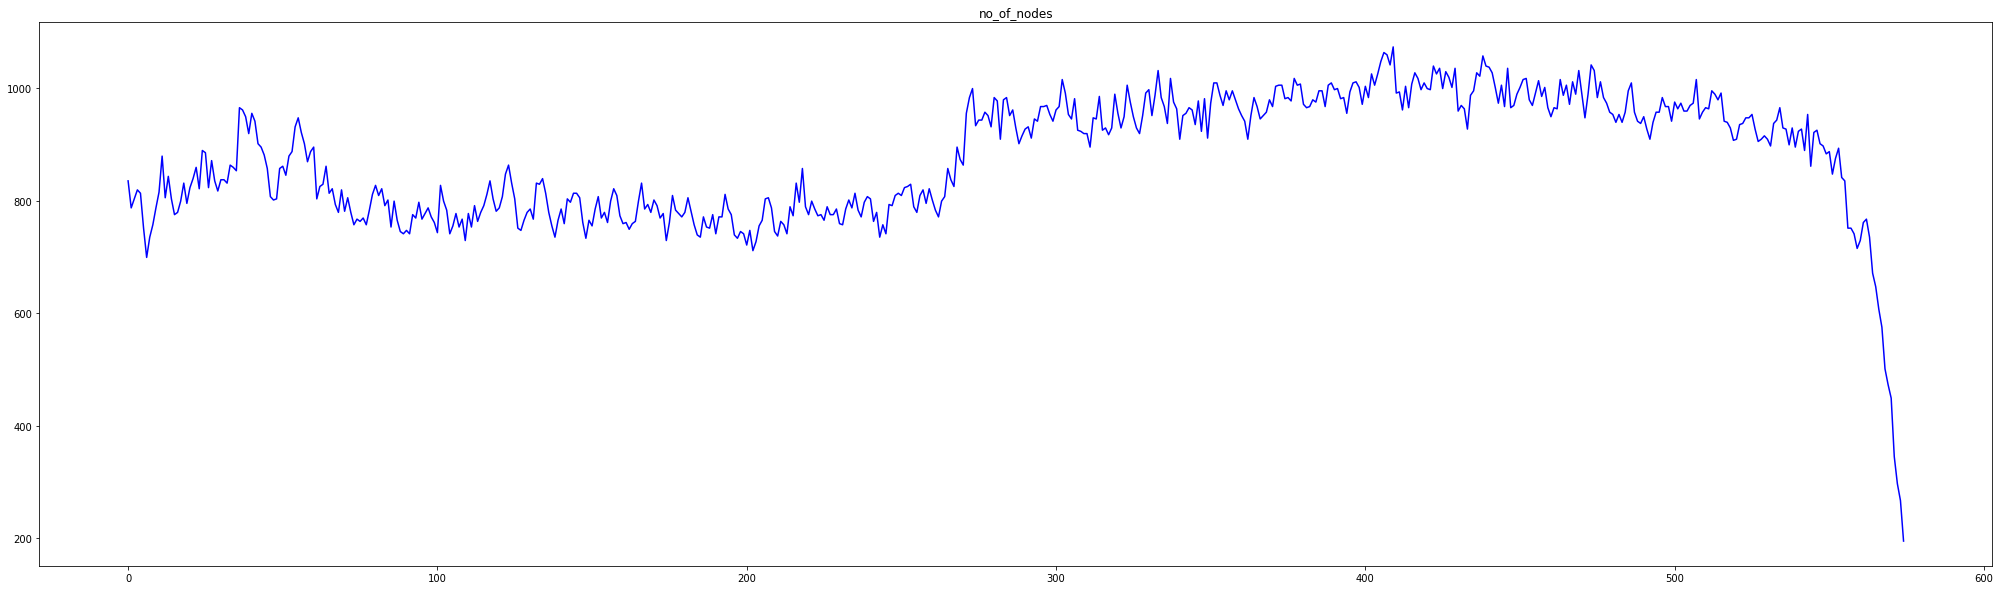

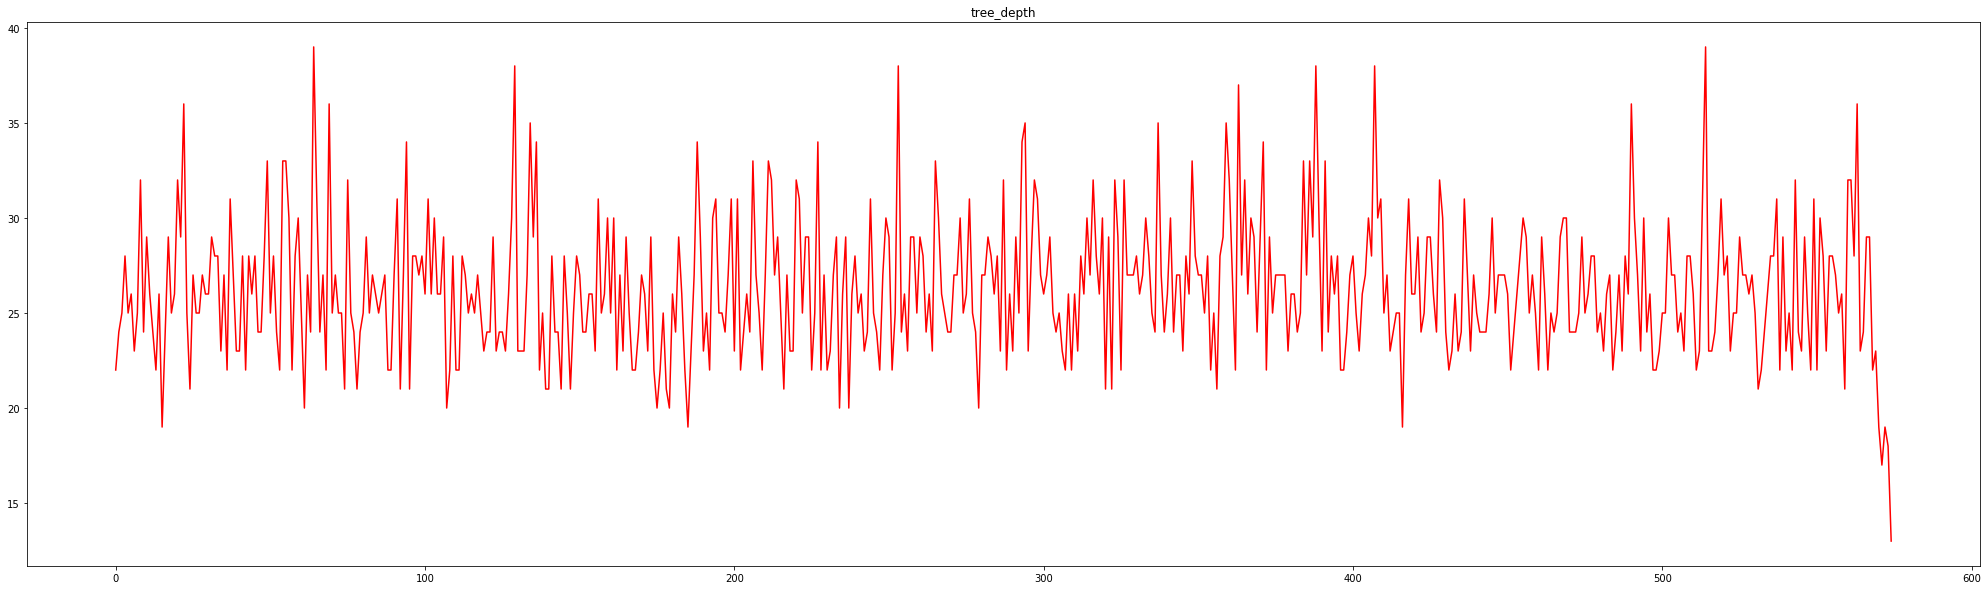

In [32]:
# plot the number of nodes for each tree
plt.figure(figsize=(35,10))
plt.title('no_of_nodes')
plt.plot(no_of_nodes, "-b")
plt.savefig('no_of_nodes_per_tree.png')

plt.figure(figsize=(35,10))
plt.title('tree_depth')
plt.plot(tree_depth, "-r")
plt.savefig('tree_depth_per_tree.png')

In [33]:
# compute further information
feature_levels_list = feature_levels.values.tolist()

# store a counter to access the dataframe index
count = 0

# iterate each row
for row in feature_levels_list:
    # count the number of NAs in a row
    no_of_NAs = row.count('NA')
    feature_levels.loc[count, 'no_of_NAs'] = no_of_NAs
    
    # find how much times feature was a root
    no_of_times_root = 0
    for item in row[4:]:
        if item.count(',0,') > 0:
            no_of_times_root += 1
    feature_levels.loc[count, 'no_of_times_root'] = no_of_times_root    
    
    # mark if all NAs
    if no_of_NAs == len(row) - 4:
        print(feature_levels.loc[count, 'features'], 'did not appear once in a tree')
        feature_levels.loc[count, 'all_NAs'] = True
    
    # increase counter
    count += 1

In [34]:
# save the dataframe with the feature levels
feature_levels.to_csv('feature_levels.csv', index = False)

In [35]:
# save the dataframe with the number of nodes
df_no_of_nodes = pd.DataFrame({'tree': tree_column, 'no_of_nodes': no_of_nodes, 'tree_depth': tree_depth, 'window_sizes': window_sizes})
df_no_of_nodes.to_csv('tree_stats.csv', index = False)